In [1]:
%load_ext jupyter_black
%matplotlib inline

In [2]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt

In [3]:
from torchvision.datasets import MNIST

train = MNIST("", download=True, train=True)
test = MNIST("", download=True, train=False)

In [4]:
X_train = train.data
y_train = train.targets
X_test = test.data
y_test = test.targets

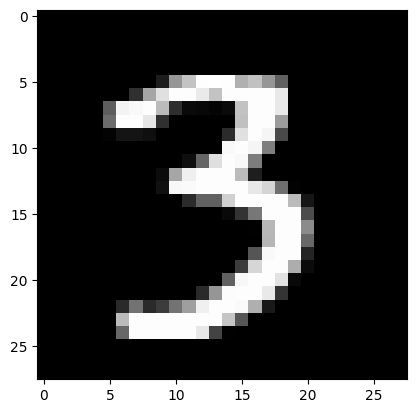

The number in the image is 3


In [5]:
image = X_train[10000]
label = y_train[10000]

plt.imshow(image, cmap="gray")
plt.show()
print("The number in the image is", label.numpy())

In [6]:
train_counts = tc.bincount(y_train).numpy()
test_counts = tc.bincount(y_test).numpy()

In [7]:
print("Training set counts:", train_counts)
print("Testing set counts:", test_counts)

Training set counts: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Testing set counts: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [8]:
X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [9]:
print("Size of X_train is", X_train.shape)
print("Size of y_train is", y_train.shape)
print("Size of X_test is", X_test.shape)
print("Size of y_test is", y_test.shape)

Size of X_train is (60000, 28, 28)
Size of y_train is (60000,)
Size of X_test is (10000, 28, 28)
Size of y_test is (10000,)


In [10]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [11]:
print("Size of X_train is", X_train.shape)
print("Size of X_test is", X_test.shape)

Size of X_train is (60000, 784)
Size of X_test is (10000, 784)


In [12]:
X_train = X_train / 255
X_test = X_test / 255

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
X_train = tc.from_numpy(X_train).float()
y_train = tc.from_numpy(y_train)
X_test = tc.from_numpy(X_test).float()
y_test = tc.from_numpy(y_test)

In [15]:
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc1_dropout = nn.Dropout(0.3)
        init.kaiming_normal_(self.fc1.weight)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc2_dropout = nn.Dropout(0.2)
        init.kaiming_normal_(self.fc2.weight)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc3_dropout = nn.Dropout(0.1)
        init.kaiming_normal_(self.fc3.weight)

        self.fc4 = nn.Linear(128, 10)
        init.xavier_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = tc.relu(x)
        x = self.fc1_dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = tc.relu(x)
        x = self.fc2_dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = tc.relu(x)
        x = self.fc3_dropout(x)

        x = self.fc4(x)

        return x

In [16]:
import torch.optim as optim

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=9e-3, weight_decay=3e-6)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

epochs = 5
losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_val_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()

    scheduler.step()

    epoch_loss /= len(train_dataset)
    losses.append(epoch_loss)

    model.eval()

    with tc.no_grad():
        for inputs, targets in test_loader:
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets)
            epoch_val_loss += val_loss.item() * inputs.size(0)

    epoch_val_loss /= len(test_dataset)
    val_losses.append(epoch_val_loss)

    model.train()

    print(
        f"Epoch: {epoch + 1}/{epochs}, Training Loss: {losses[epoch]:.4f}, Validation Loss: {val_losses[epoch]:.4f}"
    )

Epoch: 1/5, Training Loss: 0.2703, Validation Loss: 0.1474
Epoch: 2/5, Training Loss: 0.1317, Validation Loss: 0.0895
Epoch: 3/5, Training Loss: 0.0912, Validation Loss: 0.0814
Epoch: 4/5, Training Loss: 0.0704, Validation Loss: 0.0681
Epoch: 5/5, Training Loss: 0.0580, Validation Loss: 0.0637


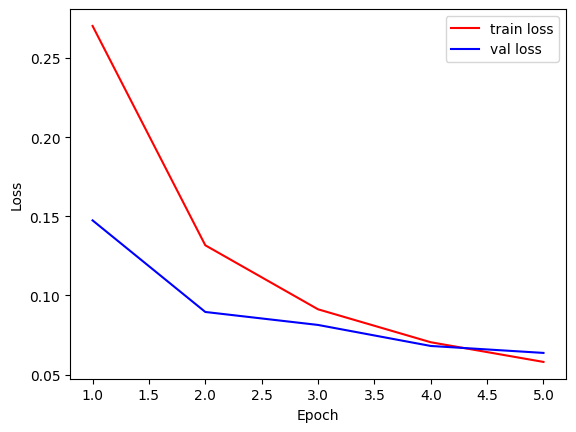

In [18]:
plt.plot(range(1, epochs + 1), losses, color="red", label="train loss")
plt.plot(range(1, epochs + 1), val_losses, color="blue", label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
model.eval()

with tc.no_grad():
    train_pred = tc.argmax(model(X_train), dim=1)
    test_pred = tc.argmax(model(X_test), dim=1)

In [20]:
from sklearn.metrics import accuracy_score

print("Training accuracy score is", accuracy_score(y_train, train_pred))
print("Testing accuracy score is", accuracy_score(y_test, test_pred))

Training accuracy score is 0.9938833333333333
Testing accuracy score is 0.981


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision score is", precision_score(y_test, test_pred, average="weighted"))
print("Recall score is", recall_score(y_test, test_pred, average="weighted"))
print("F1 score is", f1_score(y_test, test_pred, average="weighted"))

Precision score is 0.9810110347517411
Recall score is 0.981
F1 score is 0.9809943246911671


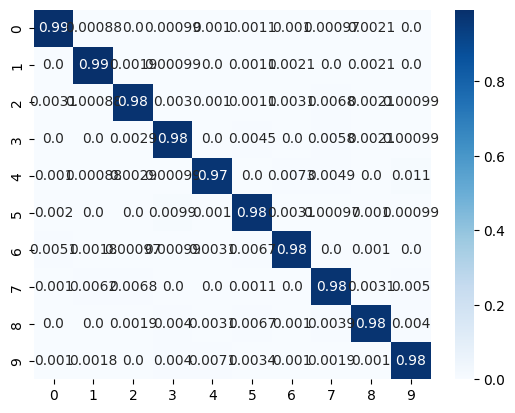

In [22]:
import seaborn as sb
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_test, test_pred)

sb.heatmap(cfm / np.sum(cfm, axis=1), annot=True, fmt=".2", cmap="Blues")
plt.show()

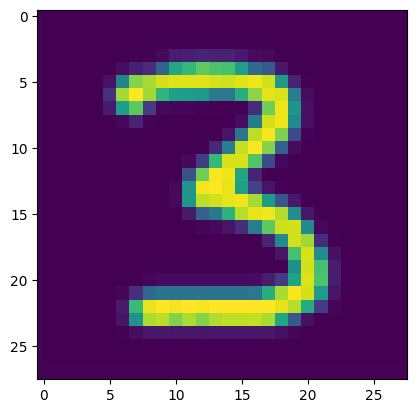

In [23]:
from PIL import Image

image = np.array(Image.open("number.png").resize((28, 28)).convert("L"))

plt.imshow(image)
plt.show()

In [24]:
image = image.reshape(1, -1)
image = image / 255
image = scaler.transform(image)
image = tc.from_numpy(image).float()

In [25]:
model.eval()

with tc.no_grad():
    prediction = tc.argmax(model(image), dim=1)

print("The model predicts the number", np.squeeze(prediction.numpy()), "in the image")

The model predicts the number 3 in the image


In [26]:
tc.save(model, "model.pth")